In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import vectorbtpro as vbt
import numpy as np
import pandas as pd

from numba import njit
import talib

# 管道优化
from vectorbtpro.returns import nb as ret_nb
from vectorbtpro.portfolio import nb as pf_nb
from vectorbtpro.portfolio.enums import Direction

vbt.settings.set_theme('dark')
# 对于 Position Sizing 问题, 可以利用 Portfolio.from_signals 接口里面的 size 参数实现

# 读取数据

In [2]:
## Load m1 data
# hdf_fname = "./data/EURUSD_H1_OHLCV_2021-01-01_2023-02-20_cleaned.h5"
# data_1h = vbt.HDFData.fetch(hdf_fname)
# selected_symbol = "EURUSD_H1_Cleaned"

hdf_fname = "./data/XAUUSD_H1_OHLCV_2020-01-01_2023-05-16_cleaned.h5"
data_1h = vbt.HDFData.fetch(hdf_fname)
selected_symbol = "XAUUSD_H1_Cleaned"

In [3]:
data_1h.wrapper.index, data_1h.wrapper.columns, data_1h.symbols

(DatetimeIndex(['2020-01-02 01:00:00+00:00', '2020-01-02 02:00:00+00:00',
                '2020-01-02 03:00:00+00:00', '2020-01-02 04:00:00+00:00',
                '2020-01-02 05:00:00+00:00', '2020-01-02 06:00:00+00:00',
                '2020-01-02 07:00:00+00:00', '2020-01-02 08:00:00+00:00',
                '2020-01-02 09:00:00+00:00', '2020-01-02 10:00:00+00:00',
                ...
                '2023-05-16 09:00:00+00:00', '2023-05-16 10:00:00+00:00',
                '2023-05-16 11:00:00+00:00', '2023-05-16 12:00:00+00:00',
                '2023-05-16 13:00:00+00:00', '2023-05-16 14:00:00+00:00',
                '2023-05-16 15:00:00+00:00', '2023-05-16 16:00:00+00:00',
                '2023-05-16 17:00:00+00:00', '2023-05-16 18:00:00+00:00'],
               dtype='datetime64[ns, UTC]', name='time', length=19924, freq=None),
 Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object'),
 ['XAUUSD_H1_Cleaned'])

In [4]:
data_h1_df = data_1h.get(symbols=selected_symbol, )
data_h1_df

,Open,High,Low,Close,Volume
time,,,,,
2020-01-02 01:00:00+00:00,1517.97,1521.37,1517.95,1518.41,3598
2020-01-02 02:00:00+00:00,1518.45,1519.37,1518.14,1518.69,2403
2020-01-02 03:00:00+00:00,1518.69,1520.91,1517.23,1519.44,6110
2020-01-02 04:00:00+00:00,1519.44,1520.95,1518.44,1520.63,3475
2020-01-02 05:00:00+00:00,1520.63,1521.21,1519.86,1520.37,1345
...,...,...,...,...,...
2023-05-16 14:00:00+00:00,2008.21,2009.32,2005.15,2005.51,4706
2023-05-16 15:00:00+00:00,2005.51,2014.86,2001.18,2011.99,11212
2023-05-16 16:00:00+00:00,2011.98,2012.34,2007.07,2007.59,12721


# 多周期数据融合

## 定义采样频率 (上 | 下 采样)

In [5]:
ori_sample_period = "1h"
down_sample_period = "1D"

In [6]:
data_1D = data_1h.resample(down_sample_period)

In [7]:
data_1D.get(symbols=selected_symbol).iloc[:3]

,Open,High,Low,Close,Volume
time,,,,,
2020-01-02 00:00:00+00:00,1517.97,1531.39,1517.23,1528.81,117976.0
2020-01-03 00:00:00+00:00,1527.43,1553.57,1527.43,1551.64,176676.0
2020-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN


In [8]:
data_1h.get(symbols=selected_symbol).iloc[[0,-1]]

,Open,High,Low,Close,Volume
time,,,,,
2020-01-02 01:00:00+00:00,1517.97,1521.37,1517.95,1518.41,3598
2023-05-16 18:00:00+00:00,2003.25,2003.69,1998.08,2001.67,5337


In [9]:
data_1D.get(symbols=selected_symbol).iloc[[0,-1]]

,Open,High,Low,Close,Volume
time,,,,,
2020-01-02 00:00:00+00:00,1517.97,1531.39,1517.23,1528.81,117976.0
2023-05-16 00:00:00+00:00,2014.02,2018.27,1998.08,2001.67,94781.0


## `多周期`索引差异性检验与处理

In [10]:
data_1h_open = data_1h.get(symbols=selected_symbol, columns=["Open"]).dropna()
data_1h_close = data_1h.get(symbols=selected_symbol, columns=["Close"]).dropna()
data_1h_high = data_1h.get(symbols=selected_symbol, columns=["High"]).dropna()
data_1h_low = data_1h.get(symbols=selected_symbol, columns=["Low"]).dropna()

# 预防未来加shift
data_1D_1h_open = data_1D.get(symbols=selected_symbol, columns=["Open"]).resample(ori_sample_period).first().ffill()
data_1D_1h_close = data_1D.get(symbols=selected_symbol, columns=["Close"]).shift(1).resample(ori_sample_period).last().ffill().shift(-1)
data_1D_1h_high = data_1D.get(symbols=selected_symbol, columns=["High"]).shift(1).resample(ori_sample_period).max().ffill().shift(-1)
data_1D_1h_low = data_1D.get(symbols=selected_symbol, columns=["Low"]).shift(1).resample(ori_sample_period).min().ffill().shift(-1)

In [11]:
data_1D_1h_open.size, data_1D_1h_close.size, data_1D_1h_high.size, data_1D_1h_low.size

(29521, 29521, 29521, 29521)

In [12]:
data_1h_open.size, data_1h_close.size, data_1h_high.size, data_1h_low.size

(19924, 19924, 19924, 19924)

In [13]:
h1_diff_1D_1h_idx = data_1h_open.index.difference(data_1D_1h_open.index)
D1_1h_diff_h1_idx = data_1D_1h_open.index.difference(data_1h_open.index)

In [14]:
from clean_data_utils import check_nan_index

print(check_nan_index(h1_diff_1D_1h_idx, freq="1h"))
print("-------------------------------------------")
print(check_nan_index(D1_1h_diff_h1_idx, freq="1h"))

原始索引大小:  18
minus_weekends (去掉周末):  18 (去掉周末之后索引大小) |  0 (周末索引大小)
minus_usfederal_holidays (节假日): 18 (去掉节假日之后索引大小) |  0 (节假日索引大小)
总结:
remaining_index_size (剩余索引大小):  18


 useless_index(无用索引大小):  0 
 无用索引: 
 Index([], dtype='object') 

 remaining_index(剩余索引大小):  18 
 剩余索引: 
 DatetimeIndex(['2023-05-16 01:00:00+00:00', '2023-05-16 02:00:00+00:00',
               '2023-05-16 03:00:00+00:00', '2023-05-16 04:00:00+00:00',
               '2023-05-16 05:00:00+00:00', '2023-05-16 06:00:00+00:00',
               '2023-05-16 07:00:00+00:00', '2023-05-16 08:00:00+00:00',
               '2023-05-16 09:00:00+00:00', '2023-05-16 10:00:00+00:00',
               '2023-05-16 11:00:00+00:00', '2023-05-16 12:00:00+00:00',
               '2023-05-16 13:00:00+00:00', '2023-05-16 14:00:00+00:00',
               '2023-05-16 15:00:00+00:00', '2023-05-16 16:00:00+00:00',
               '2023-05-16 17:00:00+00:00', '2023-05-16 18:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', freq=None)

In [15]:
data_1D_1h_open = data_1D_1h_open.drop(D1_1h_diff_h1_idx)
data_1D_1h_high = data_1D_1h_high.drop(D1_1h_diff_h1_idx)
data_1D_1h_low = data_1D_1h_low.drop(D1_1h_diff_h1_idx)
data_1D_1h_close = data_1D_1h_close.drop(D1_1h_diff_h1_idx)

In [16]:
data_1D_1h_open = pd.concat([data_1D_1h_open, 
                             pd.Series(index=h1_diff_1D_1h_idx, dtype=float).rename("Open").to_frame()], 
                             axis=0)
data_1D_1h_high = pd.concat([data_1D_1h_high, 
                             pd.Series(index=h1_diff_1D_1h_idx, dtype=float).rename("High").to_frame()], 
                             axis=0)
data_1D_1h_low = pd.concat([data_1D_1h_low, 
                            pd.Series(index=h1_diff_1D_1h_idx, dtype=float).rename("Low").to_frame()], 
                            axis=0)
data_1D_1h_close = pd.concat([data_1D_1h_close, 
                              pd.Series(index=h1_diff_1D_1h_idx, dtype=float).rename("Close").to_frame()], 
                              axis=0)

In [17]:
data_1D_1h_open.size, data_1D_1h_close.size, data_1D_1h_high.size, data_1D_1h_low.size

(19924, 19924, 19924, 19924)

# `多周期`结果校验对齐

In [18]:
h1_diff_1D_1h_idx = data_1h_open.index.difference(data_1D_1h_open.index)
D1_1h_diff_h1_idx = data_1D_1h_open.index.difference(data_1h_open.index)
h1_diff_1D_1h_idx.size, D1_1h_diff_h1_idx.size

(0, 0)

# 指标计算逻辑

## SuperTrend

### 指标定义

In [19]:
def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower

@njit
def get_final_bands_nb(close, upper, lower):
    trend = np.full(close.shape, np.nan)
    dir_ = np.full(close.shape, 1)
    long = np.full(close.shape, np.nan)
    short = np.full(close.shape, np.nan)

    for i in range(1, close.shape[0]):
        if close[i] > upper[i - 1]:
            dir_[i] = 1
        elif close[i] < lower[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lower[i] < lower[i - 1]:
                lower[i] = lower[i - 1]
            if dir_[i] < 0 and upper[i] > upper[i - 1]:
                upper[i] = upper[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lower[i]
        else:
            trend[i] = short[i] = upper[i]
            
    return trend, dir_, long, short

def faster_supertrend_talib(high, low, close, period=7, multiplier=3):
    avg_price = talib.MEDPRICE(high, low)
    atr = talib.ATR(high, low, close, period)
    upper, lower = get_basic_bands(avg_price, atr, multiplier)
    return get_final_bands_nb(close, upper, lower)

expr = """
    SuperTrend[st]:
    medprice = @talib_medprice(high, low)
    atr = @talib_atr(high, low, close, @p_period)
    upper, lower = get_basic_bands(medprice, atr, @p_multiplier)
    supert, superd, superl, supers = get_final_bands(close, upper, lower)
    supert, superd, superl, supers
"""

SuperTrend = vbt.IF.from_expr(
    expr, 
    takes_1d=True,
    get_basic_bands=get_basic_bands,
    get_final_bands=get_final_bands_nb,
    period=7, 
    multiplier=3
)

import plotly.express as px

class SuperTrend(SuperTrend):
    def get_df(self,
               column=None, 
               close_kwargs=None,
               superl_kwargs=None,
               supers_kwargs=None,
               fig=None, 
               **layout_kwargs):
        superl = self.select_col_from_obj(self.superl, column).rename('LongLine')
        supers = self.select_col_from_obj(self.supers, column).rename('ShortLine')
        superd = self.select_col_from_obj(self.superd, column).rename('Dir')
        supert = self.select_col_from_obj(self.supert, column).rename('Trend')
        
        return pd.concat([superl, supers, superd, supert], axis=1)
        
    def plot(self, 
             column=None, 
             close_kwargs=None,
             superl_kwargs=None,
             supers_kwargs=None,
             fig=None, 
             **layout_kwargs):
        close_kwargs = close_kwargs if close_kwargs else {}
        superl_kwargs = superl_kwargs if superl_kwargs else {}
        supers_kwargs = supers_kwargs if supers_kwargs else {}
        
        close = self.select_col_from_obj(self.close, column).rename('Close')
        supers = self.select_col_from_obj(self.supers, column).rename('Short')
        superl = self.select_col_from_obj(self.superl, column).rename('Long')
        
        fig = close.vbt.plot(fig=fig, **close_kwargs, **layout_kwargs)
        
        # 过滤 weekends
        # fig.update_xaxes(
        #     rangebreaks=[
        #         dict(bounds=["sat", "mon"]), #hide weekends
        #         # dict(values=["2015-12-25", "2016-01-01"])  # hide Christmas and New Year's
        #     ]
        # )
        
        supers.vbt.plot(fig=fig, **supers_kwargs)
        superl.vbt.plot(fig=fig, **superl_kwargs)
        
        return fig

### 参数选取

In [20]:
periods = np.arange(30, 80) # [30, 80]
multipliers = np.arange(10, 40, 0.5, dtype=float) # [10.0, 40.0, 0.5]

### 指标计算

In [21]:
%%time

st_indicator = SuperTrend.run(
    high=data_1h_high, low=data_1h_low, close=data_1h_close, # 输入数据
    period=periods, multiplier=multipliers, # 参数
    skipna=True,
    param_product=True,
    # chunked=dict(
    #     # n_chunks=20,
    #     execute_kwargs=dict(
    #         show_progress=True,
    #         chunk_len=20,
    #         engine="dask",
    #     ),
    # ),
    execute_kwargs=dict(
        # engine='dask',  
        show_progress=True
    )
)

# st_mtf = st_indicator.get_df(column=(PERIOD, MULTIPLIER))
# st_mtf.loc[slice("2022-05", "2022-06")]

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 11.7 s, sys: 879 ms, total: 12.5 s
Wall time: 12.5 s


In [22]:
st_indicator.getsize()

'1.9 GB'

In [23]:
st_indicator.wrapper.columns

MultiIndex([(30, 10.0),
            (30, 10.5),
            (30, 11.0),
            (30, 11.5),
            (30, 12.0),
            (30, 12.5),
            (30, 13.0),
            (30, 13.5),
            (30, 14.0),
            (30, 14.5),
            ...
            (79, 35.0),
            (79, 35.5),
            (79, 36.0),
            (79, 36.5),
            (79, 37.0),
            (79, 37.5),
            (79, 38.0),
            (79, 38.5),
            (79, 39.0),
            (79, 39.5)],
           names=['st_period', 'st_multiplier'], length=3000)

## 日频ATR带

### 指标定义

In [24]:
def atr_band_talib(h1_high, h1_low, h1_close, D1_h1_open, time_period=20, multiplier=3):
    atr_1h_val = talib.ATR(h1_high, h1_low, h1_close, time_period)
    atr_upper_band = D1_h1_open + multiplier * atr_1h_val
    atr_lower_band = D1_h1_open - multiplier * atr_1h_val
    return atr_1h_val, atr_upper_band, atr_lower_band

ATRBand = vbt.IF(
     class_name='ATRBand',
     short_name='atr_band',
     input_names=['h1_high', 'h1_low', 'h1_close', 'D1_h1_open'],
     param_names=['time_period', 'multiplier'],
     output_names=['atr_1h_val', 'atr_upper_band', 'atr_lower_band']
).with_apply_func(
     atr_band_talib, 
     takes_1d=True,  
     time_period=20,  
     multiplier=3
)

class ATRBand(ATRBand):

    def get_df(self, column=None, **layout_kwargs):
        atr_1h_val = self.select_col_from_obj(self.atr_1h_val, column).rename("ATR_1H_Val")
        atr_upper_band = self.select_col_from_obj(self.atr_upper_band, column).rename("ATR_Upper_Band")
        atr_lower_band = self.select_col_from_obj(self.atr_lower_band, column).rename("ATR_Lower_Band")
        return pd.concat([atr_1h_val, atr_upper_band, atr_lower_band], axis=1)
    
    def plot(self, 
             column=None, 
             atr_upper_band_kwargs=None,
             atr_lower_band_kwargs=None,
             fig=None, 
             **layout_kwargs):

        atr_upper_band_kwargs = atr_upper_band_kwargs if atr_upper_band_kwargs else {}
        atr_lower_band_kwargs = atr_lower_band_kwargs if atr_lower_band_kwargs else {}
        
        atr_upper_band = self.select_col_from_obj(self.atr_upper_band, column).rename("ATR_Upper_Band")
        atr_lower_band = self.select_col_from_obj(self.atr_lower_band, column).rename("ATR_Lower_Band")
        
        atr_upper_band.vbt.plot(fig=fig, **supers_kwargs)
        atr_lower_band.vbt.plot(fig=fig, **superl_kwargs)
        
        return fig

atr_band_indicator = ATRBand.run(data_1h_high["High"], data_1h_low["Low"], data_1h_close["Close"], data_1D_1h_open["Open"])
vbt.phelp(ATRBand.run)

ATRBand.run(
    h1_high,
    h1_low,
    h1_close,
    D1_h1_open,
    time_period=Default(value=20),
    multiplier=Default(value=3),
    short_name='atr_band',
    hide_params=None,
    hide_default=True,
    **kwargs
):
    Run `ATRBand` indicator.
    
    * Inputs: `h1_high`, `h1_low`, `h1_close`, `D1_h1_open`
    * Parameters: `time_period`, `multiplier`
    * Outputs: `atr_1h_val`, `atr_upper_band`, `atr_lower_band`
    
    Pass a list of parameter names as `hide_params` to hide their column levels, or True to hide all.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `ATRBand.run_pipeline`.


### 参数选取

In [25]:
atr_band_time_periods = np.array([15, 20, 25])
atr_band_multipliers = np.arange(2.5, 5.5, 0.5, dtype=float)
len(atr_band_time_periods), len(atr_band_multipliers)

(3, 6)

In [26]:
atr_band_multipliers

array([2.5, 3. , 3.5, 4. , 4.5, 5. ])

### 指标计算

In [27]:
atr_band_indicator = ATRBand.run(
    data_1h_high["High"], data_1h_low["Low"], data_1h_close["Close"], data_1D_1h_open["Open"], 
    atr_band_time_periods, atr_band_multipliers, 
    param_product=True,
    execute_kwargs=dict(show_progress=True),
)
# atr_band_df = atr_band_indicator.get_df()
# atr_band_indicator.wrapper.columns
# atr_band_df = atr_band_indicator.get_df(column=(TIME_PERIOD, N_MULTIPLIER))
# atr_band_df

  0%|          | 0/18 [00:00<?, ?it/s]

In [28]:
atr_band_indicator.getsize()

'9.4 MB'

## 指标综合可视化显示

### 参数选取

In [29]:
(PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER) = (60, 11.0, 15, 2.5)

### 可视化

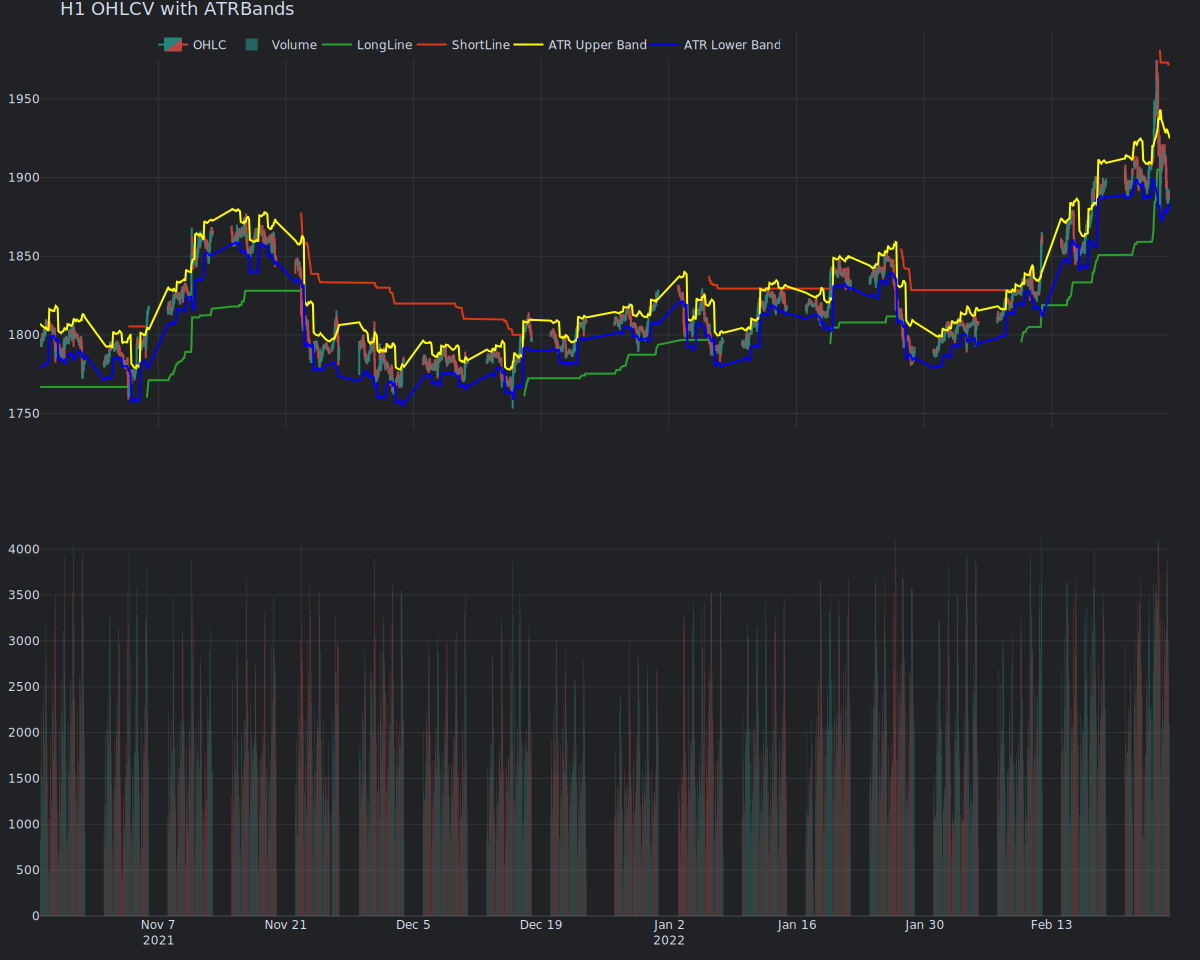

In [30]:
date_range = slice("2021-10-24", "2022-02-26")

kwargs1 = {
    "title_text" : "H1 OHLCV with ATRBands", 
    "title_font_size" : 18,
    "height" : 960,
    "width" : 1200,
    "legend" : dict(yanchor="top", y=1.0, xanchor="left", x= 0.1)
}

fig = vbt.make_subplots(rows=2,cols=1, shared_xaxes=True, vertical_spacing=0.1)

fig = data_1h.get(symbols=selected_symbol).loc[date_range, ["Open", "High", "Low", "Close", "Volume"]].vbt.ohlcv.plot(
    add_trace_kwargs=dict(row=1, col=1), fig=fig, **kwargs1
)

fig = st_indicator.get_df(column=(PERIOD, MULTIPLIER)).loc[date_range, "LongLine"]\
                  .vbt.plot(add_trace_kwargs=dict(row=1, col=1), fig=fig, **kwargs1)
fig = st_indicator.get_df(column=(PERIOD, MULTIPLIER)).loc[date_range, "ShortLine"]\
      .vbt.plot(add_trace_kwargs=dict(row=1, col=1), fig=fig, **kwargs1)

fig = atr_band_indicator.get_df(column=(TIME_PERIOD, N_MULTIPLIER)).loc[date_range, "ATR_Upper_Band"]\
                        .vbt.plot(
                            trace_kwargs=dict(line_color='yellow', name='ATR Upper Band'),
                            add_trace_kwargs=dict(
                                row=1, col=1
                            ), fig=fig, **kwargs1
                        )
fig = atr_band_indicator.get_df(column=(TIME_PERIOD, N_MULTIPLIER)).loc[date_range, "ATR_Lower_Band"]\
                        .vbt.plot(
                            trace_kwargs=dict(line_color='blue', name='ATR Lower Band'),
                            add_trace_kwargs=dict(
                                row=1, col=1
                            ), fig=fig, **kwargs1
                        )

fig.show_svg()

## 整体各指标参数组合对齐 
* [BroadCasting to make dimensions match(重要)]
* 先对齐生成指标参数组合 + 收盘价序列
* 在逐一对齐 OHLCV 序列

In [31]:
%%time

from vectorbtpro.base.reshaping import broadcast_combs
st_superd, atr_upper_band, data_1h_close_broadcasted = broadcast_combs(st_indicator.superd, atr_band_indicator.atr_upper_band, data_1h_close)

CPU times: user 5.91 s, sys: 2.71 s, total: 8.62 s
Wall time: 8.6 s


In [32]:
%%time

from vectorbtpro.base.reshaping import broadcast_combs
st_superd, atr_lower_band = broadcast_combs(st_indicator.superd, atr_band_indicator.atr_lower_band)

CPU times: user 1.17 s, sys: 1.79 s, total: 2.95 s
Wall time: 2.94 s


In [33]:
data_1h_low_broadcasted = vbt.broadcast_to(data_1h_low, data_1h_close_broadcasted, to_pd=True, axis=1)
data_1h_high_broadcasted = vbt.broadcast_to(data_1h_high, data_1h_close_broadcasted, to_pd=True, axis=1)
data_1h_open_broadcasted = vbt.broadcast_to(data_1h_open, data_1h_close_broadcasted, to_pd=True, axis=1)

In [34]:
atr_band_indicator.getsize(), st_indicator.getsize()

('9.4 MB', '1.9 GB')

In [35]:
st_indicator.getsize()

'1.9 GB'

# 进出场信号生成

## 入场信号生成

In [36]:
%%time
long_entries = ((st_superd == 1) & (data_1h_close_broadcasted >= atr_upper_band)).vbt.signals.fshift()
short_entries = (st_superd == -1) & (data_1h_close_broadcasted <= atr_lower_band).vbt.signals.fshift()

CPU times: user 23.4 s, sys: 2.55 s, total: 25.9 s
Wall time: 6.58 s


## 出入场信号生成
* 依赖于 `OHLC` 和 `入场信号`
* 分片并行化提示 (使用`@vbt.chunked`)
``` python
import vectorbtpro as vbt
import pandas as pd
import numpy as np

@vbt.chunked(
    n_chunks=10, 
    merge_func="column_stack",
    size=vbt.ArraySizer(arg_query='df', axis=1),
    arg_take_spec=dict(a=vbt.ArraySlicer(axis=1))
)
def rolling_mean(df):
    return df.rolling(100).mean()

df = pd.DataFrame(np.random.uniform(size=(1000, 1000)))
print(rolling_mean(df))
```

### DataFrame处理Decorator
* 将 np.ndarray 与 pd.DataFrame 进行对齐

In [37]:
def process_df(func):
    
    def wrapper(*args, **kwargs):
        df_args = [arg for arg in args if isinstance(arg, pd.DataFrame)]
        if len(df_args) == 0:
            return func(*args, **kwargs)

        idx_ori, cols_ori = df_args[0].index, df_args[0].columns
        res_tuple = func(*args, **kwargs)
        ret_res_tuple = tuple(pd.DataFrame(data=res, index=idx_ori, columns=cols_ori)
                              if isinstance(res, np.ndarray) else res for res in res_tuple)
        return ret_res_tuple
    
    return wrapper

### 空头止损线

In [38]:
%%time

@njit
def calc_short_trailing_st_line_single_nb(
    short_entries : np.ndarray, 
    short_entries_pos_rank : np.ndarray, 
    high_price : np.ndarray, 
    close_price : np.ndarray, 
    open_price : np.ndarray, 
    tr_decay_factor : float
) -> np.ndarray:

    short_trailing_st_line = np.full(short_entries.shape, np.nan)
    high_after_entries = np.full(short_entries.shape, np.nan)
    short_exits = np.full(short_entries.shape, False)
    short_entries = np.full(short_entries.shape, False)
    liq_ka = 1.0

    is_short_entry = False
    is_short_first_entry = False

    for i in range(len(short_entries)):
        if short_entries_pos_rank[i] == -1 and not is_short_entry:
            short_trailing_st_line[i] = np.nan
            is_short_entry = False
            is_short_first_entry = False
        elif short_entries_pos_rank[i] == -1 and is_short_entry:
            high_after_entries[i] = np.minimum(high_after_entries[i-1], high_price[i])
            liq_ka = liq_ka - 0.1
            liq_ka = np.maximum(liq_ka, 0.5)
            short_trailing_st_line[i] = high_after_entries[i] + (open_price[i] * tr_decay_factor / 1000) * liq_ka
            is_short_entry = True
            is_short_first_entry = False
        elif short_entries_pos_rank[i] == 0 and not is_short_entry:
            high_after_entries[i] = high_price[i]
            liq_ka = 1.0
            short_trailing_st_line[i] = high_after_entries[i] + (open_price[i] * tr_decay_factor / 1000) * liq_ka
            is_short_entry = True
            is_short_first_entry = True
        else:
            high_after_entries[i] = np.minimum(high_after_entries[i-1], high_price[i])
            liq_ka = liq_ka - 0.1
            liq_ka = np.maximum(liq_ka, 0.5)
            short_trailing_st_line[i] = high_after_entries[i] + (open_price[i] * tr_decay_factor / 1000) * liq_ka
            is_short_entry = True
            is_short_first_entry = False
            
        if is_short_entry and (close_price[i] >= short_trailing_st_line[i]):
            short_exits[i] = True
            is_short_entry = False
            is_short_first_entry = False
            
        short_entries[i] = is_short_first_entry and short_entries_pos_rank[i] == 0
            
    return short_trailing_st_line, high_after_entries, short_entries, short_exits

@njit(parallel=True)
def calc_short_trailing_st_line_nb(
    short_entries : np.ndarray, short_entries_pos_rank : np.ndarray, 
    high_price : np.ndarray, close_price : np.ndarray, open_price : np.ndarray, 
    tr_decay_factor : float
) -> np.ndarray:

    short_trailing_st_line_res, high_after_entries_res = np.full(short_entries.shape, np.nan), np.full(short_entries.shape, np.nan)
    short_entries_res, short_exits_res = np.full(short_entries.shape, False), np.full(short_entries.shape, False)
    
    for i in range(short_entries.shape[1]):
        (
            short_trailing_st_line_res[:, i],
            high_after_entries_res[:, i],
            short_entries_res[:, i],
            short_exits_res[:, i]
        ) = calc_short_trailing_st_line_single_nb(
            short_entries[:, i],
            short_entries_pos_rank[:, i],
            high_price[:, i],
            close_price[:, i],
            open_price[:, i],
            tr_decay_factor
        )

    return short_trailing_st_line_res, high_after_entries_res, short_entries_res, short_exits_res

@process_df
@vbt.chunked(
    n_chunks=20, 
    # chunk_len=3,
    merge_func="column_stack",
    size=vbt.ArraySizer(arg_query='short_entries', axis=1),
    arg_take_spec=dict(
        short_entries=vbt.ArraySlicer(axis=1),
        short_entries_pos_rank=vbt.ArraySlicer(axis=1),
        high_price=vbt.ArraySlicer(axis=1),
        close_price=vbt.ArraySlicer(axis=1),
        open_price=vbt.ArraySlicer(axis=1),
        tr_decay_factor=None,
    ), 
    engine="dask",
)
def calc_short_trailing_st_line(
    short_entries: pd.DataFrame, 
    short_entries_pos_rank: pd.DataFrame, 
    high_price: pd.DataFrame, 
    close_price: pd.DataFrame, 
    open_price: pd.DataFrame, 
    tr_decay_factor: float
) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    print("calling_slicer: ", short_entries.shape, short_entries_pos_rank.shape)
    return calc_short_trailing_st_line_nb(
                short_entries.values, short_entries_pos_rank.values, 
                high_price.values, close_price.values, open_price.values, 
                tr_decay_factor
           )

short_entries_pos_rank = short_entries.vbt.signals.pos_rank()

(
    short_trailing_st_line, 
    high_after_entries, 
    short_entries_out, 
    short_exits_out
) = calc_short_trailing_st_line(
    short_entries,
    short_entries_pos_rank,
    data_1h_high_broadcasted, data_1h_close_broadcasted, data_1h_open_broadcasted,
    20
)

calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
calling_slicer:  (19924, 2700) (19924, 2700)
CPU times: user 7min 5s, sys: 1min 18s, total: 8min 23s
Wall time: 1min 48s


### 多头止损线

In [39]:
%%time

@njit
def calc_long_trailing_st_line_single_nb(
    long_entries: np.ndarray, 
    long_entries_pos_rank: np.ndarray, 
    low_price: np.ndarray, 
    close_price: np.ndarray, 
    open_price: np.ndarray, 
    tr_decay_factor: float
) -> np.ndarray:

    long_trailing_st_line = np.full(long_entries.shape, np.nan)
    low_after_entries = np.full(long_entries.shape, np.nan)
    long_exits = np.full(long_entries.shape, False)
    long_entries = np.full(long_entries.shape, False)
    liq_ka = 1.0

    is_long_entry = False
    is_long_first_entry = False

    for i in range(len(long_entries)):
        if long_entries_pos_rank[i] == -1 and not is_long_entry:
            long_trailing_st_line[i] = np.nan
            is_long_entry = False
            is_long_first_entry = False
        elif long_entries_pos_rank[i] == -1 and is_long_entry:
            low_after_entries[i] = np.maximum(low_after_entries[i-1], low_price[i])
            liq_ka = liq_ka - 0.1
            liq_ka = np.maximum(liq_ka, 0.5)
            long_trailing_st_line[i] = low_after_entries[i] - (open_price[i] * tr_decay_factor / 1000) * liq_ka
            is_long_entry = True
            is_long_first_entry = False
        elif long_entries_pos_rank[i] == 0 and not is_long_entry:
            low_after_entries[i] = low_price[i]
            liq_ka = 1.0
            long_trailing_st_line[i] = low_after_entries[i] - (open_price[i] * tr_decay_factor / 1000) * liq_ka
            is_long_entry = True
            is_long_first_entry = True
        else:
            low_after_entries[i] = np.maximum(low_after_entries[i-1], low_price[i])
            liq_ka = liq_ka - 0.1
            liq_ka = np.maximum(liq_ka, 0.5)
            long_trailing_st_line[i] = low_after_entries[i] - (open_price[i] * tr_decay_factor / 1000) * liq_ka
            is_long_entry = True
            is_long_first_entry = False
            
        if is_long_entry and (close_price[i] <= long_trailing_st_line[i]):
            long_exits[i] = True
            is_long_entry = False
            is_long_first_entry = False
            
        long_entries[i] = is_long_first_entry and long_entries_pos_rank[i] == 0
            
    return long_trailing_st_line, low_after_entries, long_entries, long_exits

@njit(parallel=True)
def calc_long_trailing_st_line_nb(
    long_entries: np.ndarray, long_entries_pos_rank: np.ndarray,
    high_price: np.ndarray, close_price: np.ndarray, open_price: np.ndarray,
    tr_decay_factor: float
) -> np.ndarray:

    long_trailing_st_line_res, low_after_entries_res = np.empty_like(long_entries), np.empty_like(long_entries)
    long_entries_res, long_exits_res = np.empty_like(long_entries), np.empty_like(long_entries)
    
    long_trailing_st_line_res, low_after_entries_res = np.full(long_entries.shape, np.nan), np.full(long_entries.shape, np.nan)
    long_entries_res, long_exits_res = np.full(long_entries.shape, False), np.full(long_entries.shape, False)
    
    for i in range(long_entries.shape[1]):
        (
            long_trailing_st_line_res[:, i],
            low_after_entries_res[:, i],
            long_entries_res[:, i],
            long_exits_res[:, i]
        ) = calc_long_trailing_st_line_single_nb(
            long_entries[:, i],
            long_entries_pos_rank[:, i],
            high_price[:, i],
            close_price[:, i],
            open_price[:, i],
            tr_decay_factor
        )

    return long_trailing_st_line_res, low_after_entries_res, long_entries_res, long_exits_res

@process_df
@vbt.chunked(
    n_chunks=20, 
    # chunk_len=3,
    merge_func="column_stack",
    size=vbt.ArraySizer(arg_query='long_entries', axis=1),
    arg_take_spec=dict(
        long_entries=vbt.ArraySlicer(axis=1),
        long_entries_pos_rank=vbt.ArraySlicer(axis=1),
        low_price=vbt.ArraySlicer(axis=1),
        close_price=vbt.ArraySlicer(axis=1),
        open_price=vbt.ArraySlicer(axis=1),
        tr_decay_factor=None,
    ), 
    engine="dask",
)
def calc_long_trailing_st_line(
    long_entries: pd.DataFrame, 
    long_entries_pos_rank: pd.DataFrame, 
    low_price: pd.DataFrame, 
    close_price: pd.DataFrame, 
    open_price: pd.DataFrame, 
    tr_decay_factor: float
) -> np.ndarray:
    print("caller_long:", long_entries.shape, long_entries_pos_rank.shape)
    return calc_long_trailing_st_line_nb(
                long_entries.values, long_entries_pos_rank.values,
                low_price.values, close_price.values, open_price.values,
                tr_decay_factor
           )

long_entries_pos_rank = long_entries.vbt.signals.pos_rank()

(
    long_trailing_st_line, 
    low_after_entries, 
    long_entries_out, 
    long_exits_out
) = calc_long_trailing_st_line(
    long_entries, 
    long_entries_pos_rank, 
    data_1h_low_broadcasted, data_1h_close_broadcasted, data_1h_open_broadcasted, 
    20
)
long_trailing_st_line.shape

caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
caller_long: (19924, 2700) (19924, 2700)
CPU times: user 7min 8s, sys: 1min 21s, total: 8min 29s
Wall time: 1min 50s


(19924, 54000)

### 出入场信号后处理清洗

In [40]:
long_entries_out.values.shape, long_exits_out.values.shape, short_entries_out.values.shape, short_exits_out.values.shape

((19924, 54000), (19924, 54000), (19924, 54000), (19924, 54000))

In [41]:
long_entries_out.columns.names

FrozenList(['st_period', 'st_multiplier', 'atr_band_time_period', 'atr_band_multiplier'])

#### 出入场信号清洗

In [42]:
%%time
clean_long_entries, clean_long_exists = long_entries_out.vbt.signals.clean(long_exits_out)
clean_short_entries, clean_short_exists = short_entries_out.vbt.signals.clean(short_exits_out)

CPU times: user 1min 2s, sys: 1.58 s, total: 1min 3s
Wall time: 1min 3s


#### 出入场信号fshift防未来

In [43]:
%%time
clean_long_entries, clean_long_exists = clean_long_entries.vbt.signals.fshift(), clean_long_exists.vbt.signals.fshift()
clean_short_entries, clean_short_exists = clean_short_entries.vbt.signals.fshift(), clean_short_exists.vbt.signals.fshift()

CPU times: user 1min 30s, sys: 1.26 s, total: 1min 31s
Wall time: 1min 31s


In [44]:
clean_long_entries.memory_usage().sum() / 1024 / 1024 / 1024, "GB"

(1.0026468113064766, 'GB')

## (K线，指标，信号) - 3D全面可视化

### 参数选取

In [72]:
(PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER) = (30, 15.0, 15, 3.5)

### 可视化

In [76]:
date_range = slice("2022-09-01", "2022-09-30")

kwargs1 = {
    "title_text" : "H1 OHLCV with ATRBands", 
    "title_font_size" : 18,
    "height" : 960,
    "width" : 1200,
    "legend" : dict(yanchor="top", y=1.0, xanchor="left", x= 0.1)
}

fig = vbt.make_subplots(rows=2,cols=1, shared_xaxes=True, vertical_spacing=0.1)

fig = data_1h.get().loc[date_range, ["Open", "High", "Low", "Close", "Volume"]].vbt.ohlcv.plot(
    add_trace_kwargs=dict(row=1, col=1), fig=fig, **kwargs1
)

fig = st_indicator.get_df(column=(PERIOD, MULTIPLIER)).loc[date_range, "LongLine"]\
                  .vbt.plot(
                        add_trace_kwargs=dict(row=1, col=1), 
                        fig=fig, **kwargs1
                   )
fig = st_indicator.get_df(column=(PERIOD, MULTIPLIER)).loc[date_range, "ShortLine"]\
                  .vbt.plot(
                        add_trace_kwargs=dict(row=1, col=1), 
                        fig=fig, **kwargs1
                  )

fig = atr_band_indicator.get_df(column=(TIME_PERIOD, N_MULTIPLIER)).loc[date_range, "ATR_Upper_Band"]\
                        .vbt.plot(
                            trace_kwargs=dict(line_color='yellow', name='ATR Upper Band'),
                            add_trace_kwargs=dict(
                                row=1, col=1
                            ), fig=fig, **kwargs1
                        )
fig = atr_band_indicator.get_df(column=(TIME_PERIOD, N_MULTIPLIER)).loc[date_range, "ATR_Lower_Band"]\
                        .vbt.plot(
                            trace_kwargs=dict(line_color='blue', name='ATR Lower Band'),
                            add_trace_kwargs=dict(
                                row=1, col=1
                            ), fig=fig, **kwargs1
                        )

fig = short_trailing_st_line.loc[date_range, (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)].vbt.plot(
    trace_kwargs=dict(line_color='red', name='short_trailing_st_line'),
    add_trace_kwargs=dict(
        row=1, col=1
    ), fig=fig, **kwargs1
)
fig = long_trailing_st_line.loc[date_range, (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)].vbt.plot(
    trace_kwargs=dict(line_color='red', name='long_trailing_st_line'),
    add_trace_kwargs=dict(
        row=1, col=1
    ), fig=fig, **kwargs1
)

# fig = high_after_entries.loc[date_range, (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)].vbt.plot(
#     trace_kwargs=dict(line_color='yellow', name='high_after_entries'),
#     add_trace_kwargs=dict(
#         row=1, col=1
#     ), fig=fig, **kwargs1
# )
# fig = low_after_entries.loc[date_range, (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)].vbt.plot(
#     trace_kwargs=dict(line_color='blue', name='low_after_entries'),
#     add_trace_kwargs=dict(
#         row=1, col=1
#     ), fig=fig, **kwargs1
# )

# # fig = bbands_mtf.loc[date_range, ["lower_band"]].vbt.plot(add_trace_kwargs=dict(row=1, col=1), fig=fig, **kwargs1)
# # fig = bbands_mtf.loc[date_range, ["upper_band"]].vbt.plot(add_trace_kwargs=dict(row=1, col=1), fig=fig, **kwargs1)
# # fig = bbands_mtf.loc[date_range, ["middle_band"]].vbt.plot(add_trace_kwargs=dict(row=1, col=1), fig=fig, **kwargs1)

# fig = mtf_data.loc[date_range, ('st', 'LongLine')].vbt.plot(add_trace_kwargs=dict(row=1, col=1), fig=fig, **kwargs1)
# fig = mtf_data.loc[date_range, ('st', 'ShortLine')].vbt.plot(add_trace_kwargs=dict(row=1, col=1), fig=fig, **kwargs1)


fig = clean_long_entries.loc[date_range, (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)].vbt.signals.plot_as_entries(
    data_1h.get().loc[date_range, "Close"], fig=fig, 
    trace_kwargs=dict(name = "Long Entry", marker=dict(color="limegreen", size=12, opacity=1)),
) 
fig = clean_long_exists.loc[date_range, (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)].vbt.signals.plot_as_exits(
    data_1h.get().loc[date_range, "Close"], fig=fig, 
    trace_kwargs=dict(
        name = "Long Exit",  
        marker=dict(
            symbol="circle-open-dot", 
            color="darkblue", 
            size=20, opacity=1, 
            line=dict(width=3)
        )
    ),
)

# Shows the short_entries and short_exists

fig = clean_short_entries.loc[date_range, (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)].vbt.signals.plot_as_entries(
    data_1h.get().loc[date_range, "Close"], fig=fig, 
    trace_kwargs=dict(name = "Short Entry", marker=dict(symbol="triangle-down", color="yellow", size=12, opacity=1)),
) 
fig = clean_short_exists.loc[date_range, (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)].vbt.signals.plot_as_exits(
    data_1h.get().loc[date_range, "Close"], fig=fig, 
    trace_kwargs=dict(
        name = "Short Exit",  
        marker=dict(
            symbol="circle-open-dot", 
            color="red", 
            size=20, opacity=1, 
            line=dict(width=3)
        )
    ),
)

fig#.show_svg()

FigureWidget({
    'data': [{'close': array([1711.08, 1708.92, 1706.08, ..., 1661.96, 1661.75, 1660.93]),
              'decreasing': {'fillcolor': '#ee534f', 'line': {'color': '#ee534f'}},
              'high': array([1711.39, 1711.28, 1708.87, ..., 1664.78, 1663.19, 1662.47]),
              'increasing': {'fillcolor': '#26a69a', 'line': {'color': '#26a69a'}},
              'low': array([1705.69, 1707.76, 1705.62, ..., 1661.38, 1660.1 , 1660.43]),
              'name': 'OHLC',
              'opacity': 0.75,
              'open': array([1710.86, 1711.15, 1708.87, ..., 1662.99, 1662.03, 1661.75]),
              'type': 'candlestick',
              'uid': '33055d61-ac08-4478-bc57-6ad40c86d0ba',
              'x': array([datetime.datetime(2022, 9, 1, 1, 0, tzinfo=<UTC>),
                          datetime.datetime(2022, 9, 1, 2, 0, tzinfo=<UTC>),
                          datetime.datetime(2022, 9, 1, 3, 0, tzinfo=<UTC>), ...,
                          datetime.datetime(2022, 9, 30, 21, 0

In [47]:
long_entries_out.loc["2022-06-02 09:00:00+00:00", (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)]

False

In [48]:
clean_long_entries.loc["2022-06-02 10:00:00+00:00", (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)]

False

In [49]:
low_after_entries.loc[date_range, (PERIOD, MULTIPLIER, TIME_PERIOD, N_MULTIPLIER)]

time
2022-06-01 01:00:00+00:00        NaN
2022-06-01 02:00:00+00:00        NaN
2022-06-01 03:00:00+00:00        NaN
2022-06-01 04:00:00+00:00        NaN
2022-06-01 05:00:00+00:00        NaN
                              ...   
2023-05-16 14:00:00+00:00    2017.08
2023-05-16 15:00:00+00:00    2017.08
2023-05-16 16:00:00+00:00    2017.08
2023-05-16 17:00:00+00:00    2017.08
2023-05-16 18:00:00+00:00    2017.08
Name: (60, 11.0, 15, 2.5), Length: 5661, dtype: float64

# 超参数回测

In [50]:
long_entries.shape, short_entries.shape

((19924, 54000), (19924, 54000))

In [51]:
data_1h_close.memory_usage().sum() / 1024 / 1024 / 1024, "GB"

(0.0007890239357948303, 'GB')

In [52]:
st_superd.memory_usage().sum() / 1024 / 1024 / 1024, "GB"

(8.01669044047594, 'GB')

## 超参数组合整体回测

In [53]:
%%time
from vectorbtpro.portfolio.enums import *

pf = vbt.Portfolio.from_signals(
    close = data_1h_close, 
    long_entries = clean_long_entries, 
    long_exits = clean_long_exists, 
    short_entries = clean_short_entries,
    short_exits = clean_short_exists, 
    # direction = "both", ## This setting trades both long and short signals
    # entries=clean_short_entries, 
    # exits=clean_short_exists, 
    freq = pd.Timedelta(hours=1), 
    init_cash = 200000, # 固定10w刀, 自动算最大size
    size = 100, # 1 手 EURUSD 是 100000, 黄金： 100
    size_type = SizeType.Amount, 
    fees=0.00005, # 双边万 0.5
    slippage=0.00005, 
    chunked=dict(
        n_chunks=20,
        execute_kwargs=dict(
            show_progress=True,
            engine="dask",
        ),
    ),
)

CPU times: user 6min 41s, sys: 720 ms, total: 6min 41s
Wall time: 25.4 s


## 各超参数组合绩效分析

### 给定条件下的绩效分析

In [78]:
%%time
# Portfolio.base 里面找指标

atr_band_multiplier_cond = pf.wrapper.columns.get_level_values('atr_band_multiplier') == 4.0
atr_band_time_period_cond = pf.wrapper.columns.get_level_values('atr_band_time_period') == 15


stats_df = pf.loc[:, (atr_band_multiplier_cond & atr_band_time_period_cond)].stats(
    [
        'total_return', 
        'max_dd', 
        'max_dd_duration', 
        'total_trades', 
        'sharpe_ratio', 
        'profit_factor',
        'win_rate', 
        'expectancy', 
        'total_fees_paid', 
        # 'Max Drawdown Duration'
    ], 
    agg_func=None,
)

stats_df

CPU times: user 18.8 s, sys: 2.59 s, total: 21.4 s
Wall time: 21.4 s


Total Return [%]  \
st_period st_multiplier atr_band_time_period atr_band_multiplier                     
30        10.0          15                   4.0                          9.471414   
          10.5          15                   4.0                          6.316534   
          11.0          15                   4.0                          3.962406   
          11.5          15                   4.0                          9.955155   
          12.0          15                   4.0                         10.843687   
...                                                                            ...   
79        37.5          15                   4.0                         -4.393108   
          38.0          15                   4.0                         -5.407597   
          38.5          15                   4.0                         -4.404457   
          39.0          15                   4.0                         -4.902925   
          39.5          15                   4.0                         -5.463913   

                                                                  Max Drawdown [%]  \
st_period st_multiplier atr_band_time_period atr_band_multiplier                     
30        10.0          15                   4.0                         10.537273   
          10.5          15                   4.0                         10.734039   
          11.0          15                   4.0                         12.158954   
          11.5          15                   4.0                         10.140362   
          12.0          15                   4.0                          8.447135   
...                                                                            ...   
79        37.5          15                   4.0                         13.484836   
          38.0          15                   4.0                         14.184285   
          38.5          15                   4.0                         13.767616   
          39.0          15                   4.0                         14.245997   
          39.5          15                   4.0                         14.783158   

                                                                 Max Drawdown Duration  \
st_period st_multiplier atr_band_time_period atr_band_multiplier                         
30        10.0          15                   4.0                     470 days 19:00:00   
          10.5          15                   4.0                     436 days 06:00:00   
          11.0          15                   4.0                     436 days 06:00:00   
          11.5          15                   4.0                     436 days 06:00:00   
          12.0          15                   4.0                     360 days 15:00:00   
...                                                                                ...   
79        37.5          15                   4.0                     785 days 19:00:00   
          38.0          15                   4.0                     785 days 19:00:00   
          38.5          15                   4.0                     785 days 19:00:00   
          39.0          15                   4.0                     785 days 19:00:00   
          39.5          15                   4.0                     785 days 19:00:00   

                                                                  Total Trades  \
st_period st_multiplier atr_band_time_period atr_band_multiplier                 
30        10.0          15                   4.0                           114   
          10.5          15                   4.0                           115   
          11.0          15                   4.0                           113   
          11.5          15                   4.0                           110   
          12.0          15                   4.0                           107   
...                                                                        ...   
7

In [79]:
stats_res_df = stats_df[(stats_df["Total Trades"]>=30) 
                        & (stats_df["Max Drawdown [%]"]<=15.0) 
                        & (stats_df["Sharpe Ratio"] >= 0.50)]\
               .sort_values(['Max Drawdown [%]', 'Total Trades'], 
                            ascending=[True, False])

stats_res_df

,,,,Total Return [%],Max Drawdown [%],Max Drawdown Duration,Total Trades,Sharpe Ratio,Profit Factor,Win Rate [%],Expectancy,Total Fees Paid
st_period,st_multiplier,atr_band_time_period,atr_band_multiplier,,,,,,,,,
32,14.0,15,4.0,19.642840,5.911043,325 days 12:00:00,102,0.896246,1.428328,39.215686,385.153727,1848.159893
33,14.0,15,4.0,19.642840,5.911043,325 days 12:00:00,102,0.896246,1.428328,39.215686,385.153727,1848.159893
42,14.0,15,4.0,18.348420,5.934276,182 days 07:00:00,103,0.840093,1.397870,38.834951,356.280003,1867.579799
43,14.0,15,4.0,18.348420,5.934276,182 days 07:00:00,103,0.840093,1.397870,38.834951,356.280003,1867.579799
34,14.0,15,4.0,18.965272,5.943507,325 days 12:00:00,102,0.865545,1.413553,39.215686,371.868084,1848.227646
...,...,...,...,...,...,...,...,...,...,...,...,...
38,18.5,15,4.0,10.724343,10.392296,436 days 06:00:00,96,0.529571,1.231896,36.458333,223.423820,1737.156588
39,18.5,15,4.0,10.724343,10.392296,436 days 06:00:00,96,0.529571,1.231896,36.458333,223.423820,1737.156588
36,18.5,15,4.0,10.658850,10.445299,436 days 06:00:00,96,0.526720,1.230154,36.458333,222.059374,1737.150038


### 整体组合绩效分析

In [80]:
%%time

# stats_df = pf.stats(
#     [
#         'total_return', 
#         'max_dd', 
#         'max_dd_duration', 
#         'total_trades', 
#         'sharpe_ratio', 
#         'profit_factor',
#         'win_rate', 
#         'expectancy', 
#         'total_fees_paid', 
#     ], 
#     agg_func=None,
# )
# stats_df

CPU times: user 19 µs, sys: 3 µs, total: 22 µs
Wall time: 39.3 µs


In [81]:
# stats_res_df = stats_df[(stats_df["Total Trades"]>=30) 
#                         & (stats_df["Max Drawdown [%]"]<=8.0)]\
#                         .sort_values(['Max Drawdown [%]', 'Total Trades'], 
#                                      ascending=[True, False])

stats_res_df = stats_df[(stats_df["Sharpe Ratio"]>=0.5)]\
                        .sort_values(['Max Drawdown [%]', 'Total Trades'], 
                                     ascending=[True, False])

stats_res_df

,,,,Total Return [%],Max Drawdown [%],Max Drawdown Duration,Total Trades,Sharpe Ratio,Profit Factor,Win Rate [%],Expectancy,Total Fees Paid
st_period,st_multiplier,atr_band_time_period,atr_band_multiplier,,,,,,,,,
32,14.0,15,4.0,19.642840,5.911043,325 days 12:00:00,102,0.896246,1.428328,39.215686,385.153727,1848.159893
33,14.0,15,4.0,19.642840,5.911043,325 days 12:00:00,102,0.896246,1.428328,39.215686,385.153727,1848.159893
42,14.0,15,4.0,18.348420,5.934276,182 days 07:00:00,103,0.840093,1.397870,38.834951,356.280003,1867.579799
43,14.0,15,4.0,18.348420,5.934276,182 days 07:00:00,103,0.840093,1.397870,38.834951,356.280003,1867.579799
34,14.0,15,4.0,18.965272,5.943507,325 days 12:00:00,102,0.865545,1.413553,39.215686,371.868084,1848.227646
...,...,...,...,...,...,...,...,...,...,...,...,...
38,18.5,15,4.0,10.724343,10.392296,436 days 06:00:00,96,0.529571,1.231896,36.458333,223.423820,1737.156588
39,18.5,15,4.0,10.724343,10.392296,436 days 06:00:00,96,0.529571,1.231896,36.458333,223.423820,1737.156588
36,18.5,15,4.0,10.658850,10.445299,436 days 06:00:00,96,0.526720,1.230154,36.458333,222.059374,1737.150038


In [82]:
stats_res_df.iloc[0]

Total Return [%]                  19.64284
Max Drawdown [%]                  5.911043
Max Drawdown Duration    325 days 12:00:00
Total Trades                           102
Sharpe Ratio                      0.896246
Profit Factor                     1.428328
Win Rate [%]                     39.215686
Expectancy                      385.153727
Total Fees Paid                1848.159893
Name: (32, 14.0, 15, 4.0), dtype: object

## 对较好参数的选择性分析

In [83]:
stats_res_df.iloc[0]

Total Return [%]                  19.64284
Max Drawdown [%]                  5.911043
Max Drawdown Duration    325 days 12:00:00
Total Trades                           102
Sharpe Ratio                      0.896246
Profit Factor                     1.428328
Win Rate [%]                     39.215686
Expectancy                      385.153727
Total Fees Paid                1848.159893
Name: (32, 14.0, 15, 4.0), dtype: object

In [85]:
params_selected = (32, 14.0, 15, 4.0)

selected_pf = pf[params_selected]
selected_pf.stats(
    [
        'total_return', 
        'max_dd', 
        'max_dd_duration', 
        'total_trades', 
        'sharpe_ratio', 
        'profit_factor',
        'win_rate', 
        'expectancy', 
        'total_fees_paid', 
        # 'Max Drawdown Duration'
    ], 
    agg_func=None
)

Total Return [%]                  19.64284
Max Drawdown [%]                  5.911043
Max Drawdown Duration    325 days 12:00:00
Total Trades                           102
Sharpe Ratio                      0.896246
Profit Factor                     1.428328
Win Rate [%]                     39.215686
Expectancy                      385.153727
Total Fees Paid                1848.159893
Name: (32, 14.0, 15, 4.0), dtype: object

## PnL计算逻辑检查
* $calc\_ret=size * profit - {entry\_fees} - exit\_fees$

In [86]:
# 显示出场订单
selected_exit_trades_df = selected_pf.get_exit_trades().records_readable
analysis_selected_exit_trades_df = selected_exit_trades_df[selected_exit_trades_df["Column"]==params_selected]
analysis_selected_exit_trades_df.head()

,Exit Trade Id,Column,Size,Entry Order Id,Entry Index,Avg Entry Price,Entry Fees,Exit Order Id,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,"(32, 14.0, 15, 4.0)",100.0,0,2020-01-02 19:00:00+00:00,1525.366265,7.626831,1,2020-01-07 04:00:00+00:00,1558.952049,7.794760,3343.156808,0.021917,Long,Closed,0
1,1,"(32, 14.0, 15, 4.0)",100.0,2,2020-02-14 01:00:00+00:00,1577.438868,7.887194,3,2020-02-24 22:00:00+00:00,1659.527019,8.297635,8192.630321,0.051936,Long,Closed,1
2,2,"(32, 14.0, 15, 4.0)",100.0,4,2020-02-28 19:00:00+00:00,1583.640814,7.918204,5,2020-03-02 07:00:00+00:00,1604.080200,8.020401,-2059.877205,-0.013007,Short,Closed,2
3,3,"(32, 14.0, 15, 4.0)",100.0,6,2020-03-11 01:00:00+00:00,1652.967347,8.264837,7,2020-03-13 09:00:00+00:00,1587.229358,7.936147,6557.598016,0.039672,Short,Closed,3
4,4,"(32, 14.0, 15, 4.0)",100.0,8,2020-03-16 15:00:00+00:00,1455.587217,7.277936,9,2020-03-16 18:00:00+00:00,1503.995196,7.519976,-4855.595812,-0.033358,Short,Closed,4


In [87]:
size_ser = analysis_selected_exit_trades_df["Size"]
avg_entry_price_ser = analysis_selected_exit_trades_df["Avg Entry Price"]
avt_exit_price_ser = analysis_selected_exit_trades_df["Avg Exit Price"]
entry_fees_ser = analysis_selected_exit_trades_df["Entry Fees"]
exit_fees_ser = analysis_selected_exit_trades_df["Exit Fees"]
direction_ser = analysis_selected_exit_trades_df["Direction"]
absolute_price_diff = np.where(
    direction_ser.eq("Long"),
    avt_exit_price_ser - avg_entry_price_ser,
    -(avt_exit_price_ser - avg_entry_price_ser)
)
calc_ret = size_ser * absolute_price_diff - entry_fees_ser - exit_fees_ser
analysis_selected_exit_trades_df["calc_ret"] = calc_ret
analysis_selected_exit_trades_df.head()

,Exit Trade Id,Column,Size,Entry Order Id,Entry Index,Avg Entry Price,Entry Fees,Exit Order Id,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id,calc_ret
0,0,"(32, 14.0, 15, 4.0)",100.0,0,2020-01-02 19:00:00+00:00,1525.366265,7.626831,1,2020-01-07 04:00:00+00:00,1558.952049,7.794760,3343.156808,0.021917,Long,Closed,0,3343.156808
1,1,"(32, 14.0, 15, 4.0)",100.0,2,2020-02-14 01:00:00+00:00,1577.438868,7.887194,3,2020-02-24 22:00:00+00:00,1659.527019,8.297635,8192.630321,0.051936,Long,Closed,1,8192.630321
2,2,"(32, 14.0, 15, 4.0)",100.0,4,2020-02-28 19:00:00+00:00,1583.640814,7.918204,5,2020-03-02 07:00:00+00:00,1604.080200,8.020401,-2059.877205,-0.013007,Short,Closed,2,-2059.877205
3,3,"(32, 14.0, 15, 4.0)",100.0,6,2020-03-11 01:00:00+00:00,1652.967347,8.264837,7,2020-03-13 09:00:00+00:00,1587.229358,7.936147,6557.598016,0.039672,Short,Closed,3,6557.598016
4,4,"(32, 14.0, 15, 4.0)",100.0,8,2020-03-16 15:00:00+00:00,1455.587217,7.277936,9,2020-03-16 18:00:00+00:00,1503.995196,7.519976,-4855.595812,-0.033358,Short,Closed,4,-4855.595812


## 可视化

In [88]:
selected_pf.plot()#.show_svg()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'mode': 'lines',
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'd4a883ca-0b4f-4223-8860-75e0e46f788f',
              'x': array([datetime.datetime(2020, 1, 2, 1, 0, tzinfo=<UTC>),
                          datetime.datetime(2020, 1, 2, 2, 0, tzinfo=<UTC>),
                          datetime.datetime(2020, 1, 2, 3, 0, tzinfo=<UTC>), ...,
                          datetime.datetime(2023, 5, 16, 16, 0, tzinfo=<UTC>),
                          datetime.datetime(2023, 5, 16, 17, 0, tzinfo=<UTC>),
                          datetime.datetime(2023, 5, 16, 18, 0, tzinfo=<UTC>)], dtype=object),
              'xaxis': 'x',
              'y': array([1518.41, 1518.69, 1519.44, ..., 2007.59, 2003.25, 2001.67]),
              'yaxis': 'y'},
             {'customdata': array([['0', '2020-01-02 19:00:00+00:00', '2020-01-02 19

In [89]:
selected_pf.plot_drawdowns()#.show_svg()

FigureWidget({
    'data': [{'line': {'color': '#9467bd'},
              'mode': 'lines',
              'name': 'Value',
              'showlegend': True,
              'type': 'scatter',
              'uid': '0082ddd9-9413-42a1-870b-4e690774b9e7',
              'x': array([datetime.datetime(2020, 1, 2, 1, 0, tzinfo=<UTC>),
                          datetime.datetime(2020, 1, 2, 2, 0, tzinfo=<UTC>),
                          datetime.datetime(2020, 1, 2, 3, 0, tzinfo=<UTC>), ...,
                          datetime.datetime(2023, 5, 16, 16, 0, tzinfo=<UTC>),
                          datetime.datetime(2023, 5, 16, 17, 0, tzinfo=<UTC>),
                          datetime.datetime(2023, 5, 16, 18, 0, tzinfo=<UTC>)], dtype=object),
              'y': array([200000.        , 200000.        , 200000.        , ..., 239285.68010745,
                          239285.68010745, 239285.68010745])},
             {'customdata': array([['21', '2020-03-13 04:00:00+00:00', 219262.37983718992],
        

In [90]:
pf.getsize()

'993.7 MB'